In [69]:
import os
os.chdir("/bask/projects/r/ranaaaa-hackathon-1")

In [70]:
print(os.getcwd())

/bask/projects/r/ranaaaa-hackathon-1


In [71]:
import os
print(os.path.expanduser("~")) 


/bask/homes/k/kxy181


In [195]:
## CALCULATE SECONDARY STRUCTURE BONDS AND MFE FOR EACH SEQUENCE
import RNA
import Bio
from Bio.Seq import Seq
from Bio.SeqUtils import gc_fraction
import RNA
 
# define function to calculate bonds and MFE
def calculate_bonds_mfe(dna_sequence):
 
    # predict secondary structure and calculate bonds and MFE
    fold_comp = RNA.fold_compound(dna_sequence)
    structure, mfe = fold_comp.mfe()  # get secondary structure and MFE
 
    num_bonds = structure.count("(")  # count base pairs
 
    return num_bonds, mfe  # return number of bonds and mfe

## CALCULATE NUCLEOTIDE COMPOSITION
 
# function to calculate nucleotide composition 
def nucleotide_comp(sequence):
    # count number of each base (C, A, G) in the sequence 
    a_count = sequence.count('A')
    c_count = sequence.count('C')
    g_count = sequence.count('G')
    return a_count, c_count, g_count

# function to calculate GC content 
def calculate_gc_content(seq):
    sequence = Seq(seq)  # store sequence as a Bioseq object 
    gc_content = round(gc_fraction(sequence) * 100, 1)
    return gc_content

In [213]:
new_seq = 'GAAGACAACGCTTC' ## first 14
sequence_CI.append(new_seq)
template_sequence = new_seq+'GATCTCGAAGACAACG'  ## template sequence
print(template_sequence)

#### calulate the sequence features for the input sequence
bonds,mfe = calculate_bonds_mfe(template_sequence)
a,c,g = nucleotide_comp(template_sequence)
gc = calculate_gc_content(template_sequence)


GAAGACAACGCTTCGATCTCGAAGACAACG


In [215]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, TrainingArguments, Trainer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### read data, only read CI and CII sequences ######
file_path = "/bask/homes/k/kxy181/384_sequences_for_validation.xlsx" 
df = pd.read_excel(file_path, header=1)
filtered_df = df[df['Results'].isin(['CI', 'CII'])]
sequence_CI = filtered_df['Template_Sequence'].astype(str).str[:14].tolist()
results = filtered_df['Results'].tolist()

##### concatenate the new seq to trained data ######
sequence_CI.append(new_seq)
results.append('UN')
print(len(sequence_CI))
print(len(results))

##### factor mapping to number ####
level_to_color = {'CI': 0, 'CII': 1, 'UN': 2}
level_colors = [level_to_color[level] for level in results]
results = level_colors

print(level_to_color)

### add sequence features #######
file_path_a = "/bask/homes/k/kxy181/features_df_265.csv" 
df_a = pd.read_csv(file_path_a)
filtered_df = filtered_df.reset_index(drop=True)
df_a_CI = df_a[df_a['Results'].isin(['CI','CII'])][['ViennaRNA_bonds', 'MFE', 'C_Count', 'A_Count', 'G_Count', 'GC_content']]
df_a_CI = df_a_CI.reset_index(drop=True)

####### not include P90,N10,Diff ######
# additional_features = pd.concat([
#     df_a_CI,
#     filtered_df[['P90', 'N10', 'Diff']]
# ], axis=1)

additional_features = df_a_CI
print(additional_features)

from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

# Import the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref")
model = AutoModelForMaskedLM.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref")

# Choose the length to which the input sequences are padded. By default, the 
# model max length is chosen, but feel free to decrease it as the time taken to 
# obtain the embeddings increases significantly with it.
max_length = tokenizer.model_max_length

# Create a dummy dna sequence and tokenize it
sequences = sequence_CI
tokens_ids = tokenizer.batch_encode_plus(sequences, return_tensors="pt", padding="max_length", max_length = 15)["input_ids"]

# Compute the embeddings
attention_mask = tokens_ids != tokenizer.pad_token_id
torch_outs = model(
    tokens_ids,
    attention_mask=attention_mask,
    encoder_attention_mask=attention_mask,
    output_hidden_states=True
)
# Compute sequences embeddings
embeddings_CI = torch_outs['hidden_states'][-1].detach().numpy()

valid_length = (tokens_ids != tokenizer.pad_token_id).sum().item()  
embeddings_CI = embeddings_CI[:, :valid_length, :]

print(f"Embeddings shape: {embeddings_CI.shape}")

import numpy as np

mean_pooled = np.mean(embeddings_CI, axis=1)
#### mean pooling ####
sequence_embeddings_CI = mean_pooled
print(sequence_embeddings_CI.shape)

179
179
{'CI': 0, 'CII': 1, 'UN': 2}
     ViennaRNA_bonds  MFE  C_Count  A_Count  G_Count  GC_content
0                0.0  0.0     11.0      8.0      5.0        53.3
1                0.0  0.0     11.0      8.0      3.0        46.7
2                7.0 -3.6     11.0      8.0      7.0        60.0
3                0.0  0.0     11.0      8.0      3.0        46.7
4                6.0 -2.1     11.0      6.0      7.0        60.0
..               ...  ...      ...      ...      ...         ...
173              6.0 -2.1      8.0      9.0      6.0        46.7
174              8.0 -3.7      8.0      7.0      7.0        50.0
175              4.0 -0.4      4.0      7.0     12.0        53.3
176              7.0 -2.0      9.0     12.0      6.0        50.0
177              0.0  0.0     13.0      6.0      3.0        53.3

[178 rows x 6 columns]
Embeddings shape: (179, 15, 1280)
(179, 1280)


In [216]:
import numpy as np
import pandas as pd
import umap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

#### split the transet and the new seq ####
index=178
X_train = sequence_embeddings_CI[:index]
print(X_train.shape)
y_train = np.array(results[:index]) 
print(y_train)
X_unknown = sequence_embeddings_CI[index].reshape(1, -1)  # 最后一个样本


(178, 1280)
[0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0
 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0
 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0 0 1 1 1 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0]


In [217]:
##### LLM and then XGBoost #####
import warnings
import umap
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneOut

# Initialize variables to track best performance
best_acc = 0
best_dim = None
best_params = {}
best_cm = None

# Hyperparameter ranges
umap_dims = range(2, 10)  # UMAP dimensions to try
xgb_params = {
    'max_depth': [3,5,7,9]
    'n_estimators': [50,100,200],
    'learning_rate': [0.01,0.1]
}

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="umap")
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# Grid search implementation
for d in umap_dims:
    print(f"Current UMAP dimension: {d}")
    
    # Generate all parameter combinations
    from itertools import product
    param_combinations = product(xgb_params['max_depth'], 
                                xgb_params['n_estimators'], 
                                xgb_params['learning_rate'])
    
    for max_depth, n_estimators, lr in param_combinations:
        print(f"Testing XGB params - depth: {max_depth}, estimators: {n_estimators}, lr: {lr}")
        
        y_true_all = []
        y_pred_all = []
        correct = 0
        
        # Leave-One-Out cross-validation
        loo = LeaveOneOut()
        for train_idx, test_idx in loo.split(X_train):
            # Split data
            X_train_fold = X_train[train_idx]
            y_train_fold = y_train[train_idx]
            X_test_fold = X_train[test_idx]
            y_test_fold = y_train[test_idx]
            
            # Apply UMAP
            umap_model = umap.UMAP(n_components=d, random_state=10, n_epochs=100).fit(X_train_fold,y_train_fold)
            X_train_embedded = umap_model.fit_transform(X_train_fold)
            X_test_embedded = umap_model.transform(X_test_fold)
            
            # Add additional features
            X_train_full = np.concatenate((X_train_embedded, additional_features.iloc[train_idx]), axis=1)
            X_test_full = np.concatenate((X_test_embedded, additional_features.iloc[test_idx]), axis=1)
            
            # Train XGBoost model
            xgb = XGBClassifier(
                max_depth=max_depth,
                n_estimators=n_estimators,
                learning_rate=lr,
                use_label_encoder=False,
                eval_metric='logloss',
                random_state=42
            )
            xgb.fit(X_train_full, y_train_fold)
            
            # Make prediction
            y_pred = xgb.predict(X_test_full)
            
            # Track performance
            y_true_all.append(y_test_fold[0])
            y_pred_all.append(y_pred[0])
            if y_pred[0] == y_test_fold[0]:
                correct += 1
        
        # Calculate metrics
        acc = accuracy_score(y_true_all, y_pred_all)
        cm = confusion_matrix(y_true_all, y_pred_all)
        
        # Update best parameters
        if acc > best_acc:
            best_acc = acc
            best_dim = d
            best_params = {'max_depth': max_depth, 
                          'n_estimators': n_estimators, 
                          'learning_rate': lr}
            best_cm = cm

# Train final model with best parameters
print("\nTraining final model...")
final_umap = umap.UMAP(n_components=best_dim, random_state=10)
X_train_embedded = final_umap.fit_transform(X_train)

# Add additional features to full dataset
X_train_full = np.concatenate((X_train_embedded, additional_features), axis=1)

# Initialize and train XGBoost
final_model = XGBClassifier(
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
final_model.fit(X_train_full, y_train)

additional_features_unknown = np.array([bonds, mfe, c, a, g, gc]).reshape(1, -1)
print(additional_features_unknown)

print(X_unknown_embeddings.shape)
# Predict unknown sample
X_unknown_embedded = final_umap.transform(X_unknown)
X_unknown_full = np.concatenate((X_unknown_embedded, additional_features_unknown), axis=1)
y_pred_unknown = final_model.predict(X_unknown_full)

# Print results
print("\n=== Best Parameters ===")
print(f"UMAP dimension: {best_dim}")
print(f"XGBoost parameters: {best_params}")
print(f"\n=== Best Model Performance ===")
print(f"LOO Accuracy: {best_acc:.4f}")
print("Confusion Matrix:")
print(best_cm.T)
print(f"\n=== Prediction ===")
print(f"New sequence prediction: {y_pred_unknown[0]}")

Current UMAP dimension: 4
Testing XGB params - depth: 3, estimators: 50, lr: 0.01
Testing XGB params - depth: 3, estimators: 50, lr: 0.1
Testing XGB params - depth: 5, estimators: 50, lr: 0.01
Testing XGB params - depth: 5, estimators: 50, lr: 0.1
Current UMAP dimension: 5
Testing XGB params - depth: 3, estimators: 50, lr: 0.01
Testing XGB params - depth: 3, estimators: 50, lr: 0.1
Testing XGB params - depth: 5, estimators: 50, lr: 0.01
Testing XGB params - depth: 5, estimators: 50, lr: 0.1
Current UMAP dimension: 6
Testing XGB params - depth: 3, estimators: 50, lr: 0.01
Testing XGB params - depth: 3, estimators: 50, lr: 0.1
Testing XGB params - depth: 5, estimators: 50, lr: 0.01
Testing XGB params - depth: 5, estimators: 50, lr: 0.1

Training final model...
[[ 5. -5.  8. 11.  7. 50.]]
(1, 1280)

=== Best Parameters ===
UMAP dimension: 4
XGBoost parameters: {'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.1}

=== Best Model Performance ===
LOO Accuracy: 0.7416
Confusion Matrix:


In [223]:
print("\n=== Best Parameters ===")
print(f"UMAP dimension: {best_dim}")
print(f"XGBoost parameters: {best_params}")
print(f"\n=== Best Model Performance ===")
# print(f"LOO Accuracy: {best_acc:.4f}")
print("Confusion Matrix:")
print(best_cm.T)
print(f"\n=== Prediction ===")
print(f"New sequence prediction: {y_pred_unknown[0]}")
print('(CI: 0, CII: 1)')


=== Best Parameters ===
UMAP dimension: 4
XGBoost parameters: {'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.1}

=== Best Model Performance ===
Confusion Matrix:
[[76 24]
 [22 56]]

=== Prediction ===
New sequence prediction: 1
(CI: 0, CII: 1)


In [40]:
########### supervised UMAP visulization for all data ################
########### not used for the final model

from transformers import AutoTokenizer, AutoModelForMaskedLM, TrainingArguments, Trainer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

file_path = "/bask/homes/k/kxy181/384_sequences_for_validation.xlsx" 
df = pd.read_excel(file_path, header=1)
filtered_df = df[df['Results'].isin(['CI', 'CII', 'CIII'])]
sequence_CI = filtered_df['Template_Sequence'].astype(str).str[:14].tolist()
results = filtered_df['Results']
print(len(sequence_CI))
print(len(results))

from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

# Import the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref")
model = AutoModelForMaskedLM.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref")

# Choose the length to which the input sequences are padded. By default, the 
# model max length is chosen, but feel free to decrease it as the time taken to 
# obtain the embeddings increases significantly with it.
max_length = tokenizer.model_max_length

# Create a dummy dna sequence and tokenize it
sequences = sequence_CI
tokens_ids = tokenizer.batch_encode_plus(sequences, return_tensors="pt", padding="max_length", max_length = 14)["input_ids"]

# Compute the embeddings
attention_mask = tokens_ids != tokenizer.pad_token_id
torch_outs = model(
    tokens_ids,
    attention_mask=attention_mask,
    encoder_attention_mask=attention_mask,
    output_hidden_states=True
)
# Compute sequences embeddings
embeddings_CI = torch_outs['hidden_states'][-1].detach().numpy()

valid_length = (tokens_ids != tokenizer.pad_token_id).sum().item()  
embeddings_CI = embeddings_CI[:, :valid_length, :]

print(f"Embeddings shape: {embeddings_CI.shape}")

265
265
Embeddings shape: (265, 14, 1280)


In [41]:
levels=df[df['Results'].isin(['CI', 'CII', 'CIII'])]['Results']
unique_levels = list(set(levels))  
print(unique_levels)
level_to_color = {level: i for i, level in enumerate(unique_levels)}  
level_colors = [level_to_color[level] for level in levels]  
results = level_colors
print(level_to_color)
print(results)


['CIII', 'CI', 'CII']
{'CIII': 0, 'CI': 1, 'CII': 2}
[1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 2, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0, 1, 0, 2, 2, 1, 1, 0, 1, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 0, 1, 2, 2, 1, 0, 0, 2, 0, 1, 0, 2, 0, 0, 2, 1, 2, 2, 2, 2, 1, 1, 0, 2, 0, 2, 0, 0, 1, 2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 2, 2, 1, 2, 0, 2, 0, 1, 2, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 2, 0, 2, 0, 0, 1, 1, 0, 1, 2, 2, 0, 2, 2, 1, 1, 0, 1, 2, 0, 1, 0, 0, 1, 1, 1, 2, 1, 1, 2, 0, 2, 1, 2, 2, 1, 1, 1, 0, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 2, 2, 0, 2, 2, 1, 2, 1, 1, 2, 1, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 1, 1, 2, 1, 2, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 2, 2, 0, 1, 1, 0, 0, 0, 2, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 2, 0, 1, 1, 1, 1, 2, 1, 0, 1, 2, 2, 2, 1, 2, 2, 1, 0, 2, 1, 2, 0, 1, 2, 1]


/bask/homes/k/kxy181/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/bask/homes/k/kxy181/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/bask/homes/k/kxy181/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


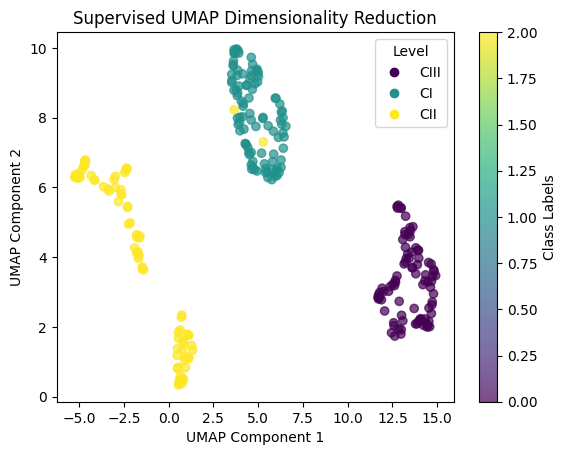

In [42]:
import numpy as np

mean_pooled = np.mean(embeddings_CI, axis=1)
max_pooled = np.max(embeddings_CI, axis=1) 
sequence_embeddings_CI = np.concatenate([mean_pooled, max_pooled], axis=1)  # (265, 2560)

from sklearn.decomposition import PCA
import umap

import umap.plot
supervised_umap_2 = umap.UMAP(n_components=2, random_state=10).fit(sequence_embeddings_CI, results)

# 可视化监督 UMAP 结果
import matplotlib.pyplot as plt

scatter=plt.scatter(supervised_umap_2.embedding_[:, 0], supervised_umap_2.embedding_[:, 1], c=results, cmap='viridis', alpha=0.7)
handles = [plt.Line2D([], [], marker='o', linestyle='', color=scatter.cmap(scatter.norm(i)), label=level) for i, level in enumerate(unique_levels)]
plt.legend(handles=handles, title="Level")
plt.colorbar(label="Class Labels")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("Supervised UMAP Dimensionality Reduction")
plt.show()

In [83]:
###############  for KNN classifier (bad performance)         #######################
from transformers import AutoTokenizer, AutoModelForMaskedLM, TrainingArguments, Trainer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

file_path = "/bask/homes/k/kxy181/384_sequences_for_validation.xlsx" 
df = pd.read_excel(file_path, header=1)
filtered_df = df[df['Results'].isin(['CI', 'CII'])]
sequence_CI = filtered_df['Template_Sequence'].astype(str).str[:14].tolist()
sequence_CI=sequence_CI
results = filtered_df['Results'].tolist()

sequence_CI.append('GAAGACAACGCTTCA')
results.append('UN')
print(len(sequence_CI))
print(len(results))

levels=results
unique_levels = list(set(levels))  
print(unique_levels)
level_to_color = {level: i for i, level in enumerate(unique_levels)}  
level_colors = [level_to_color[level] for level in levels]  
results = level_colors
print(level_to_color)

file_path_a = "/bask/homes/k/kxy181/features_df_265.csv" 
df_a = pd.read_csv(file_path_a)

additional_features = df_a[['ViennaRNA_bonds','MFE','C_Count','A_Count','G_Count','GC_content']]
print(additional_features)

from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

# Import the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref")
model = AutoModelForMaskedLM.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref")

# Choose the length to which the input sequences are padded. By default, the 
# model max length is chosen, but feel free to decrease it as the time taken to 
# obtain the embeddings increases significantly with it.
max_length = tokenizer.model_max_length

# Create a dummy dna sequence and tokenize it
sequences = sequence_CI
tokens_ids = tokenizer.batch_encode_plus(sequences, return_tensors="pt", padding="max_length", max_length = 15)["input_ids"]

# Compute the embeddings
attention_mask = tokens_ids != tokenizer.pad_token_id
torch_outs = model(
    tokens_ids,
    attention_mask=attention_mask,
    encoder_attention_mask=attention_mask,
    output_hidden_states=True
)
# Compute sequences embeddings
embeddings_CI = torch_outs['hidden_states'][-1].detach().numpy()

valid_length = (tokens_ids != tokenizer.pad_token_id).sum().item()  
embeddings_CI = embeddings_CI[:, :valid_length, :]

print(f"Embeddings shape: {embeddings_CI.shape}")

import numpy as np

mean_pooled = np.mean(embeddings_CI, axis=1)
max_pooled = np.max(embeddings_CI, axis=1) 
sequence_embeddings_CI = mean_pooled
# sequence_embeddings_CI = np.concatenate([mean_pooled, max_pooled], axis=1) 
print(sequence_embeddings_CI.shape)

179
179
['CI', 'UN', 'CII']
{'CI': 0, 'UN': 1, 'CII': 2}
     ViennaRNA_bonds  MFE  C_Count  A_Count  G_Count  GC_content
0                0.0  0.0     11.0      8.0      5.0        53.3
1                0.0  0.0     11.0      8.0      3.0        46.7
2                7.0 -3.6     11.0      8.0      7.0        60.0
3                4.0 -4.2      9.0      8.0      7.0        53.3
4                8.0 -6.1     11.0      6.0      7.0        60.0
..               ...  ...      ...      ...      ...         ...
260              8.0 -3.7      8.0      7.0      7.0        50.0
261              8.0 -3.0      9.0      8.0      6.0        50.0
262              4.0 -0.4      4.0      7.0     12.0        53.3
263              7.0 -2.0      9.0     12.0      6.0        50.0
264              0.0  0.0     13.0      6.0      3.0        53.3

[265 rows x 6 columns]
Embeddings shape: (179, 15, 1280)
(179, 1280)


In [78]:
import numpy as np
import pandas as pd
import umap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

index=178
X_train = sequence_embeddings_CI[:index]
print(X_train.shape)
y_train = np.array(results[:index]) 
print(y_train)
X_unknown = sequence_embeddings_CI[index].reshape(1, -1)  # 最后一个样本




(178, 1280)
[0 0 0 0 0 0 0 2 0 2 0 0 0 2 2 0 0 0 2 2 0 2 0 2 2 0 2 0 2 2 0 2 2 2 2 0 0
 2 2 0 2 2 2 2 2 2 0 2 0 0 2 2 0 2 2 2 0 2 2 0 2 0 0 0 0 0 0 0 0 0 0 0 2 2
 0 0 0 2 2 2 2 0 0 0 2 0 0 0 0 2 0 0 2 2 0 2 2 0 0 0 0 2 2 0 2 0 2 0 0 2 0
 0 0 2 2 2 2 0 2 0 0 2 0 2 2 2 2 2 2 0 0 2 0 2 2 0 0 0 0 2 2 2 2 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 2 2 2 0 2 2 0 2 0 2 0 2 0]


In [80]:
################# KNN classifier #######################
################# bad performance #######################
import warnings
import umap

best_acc = 0
best_dim = None
best_k = None

umap_dims = range(2, 3)  
knn_neighbors = range(1, 8)  

warnings.filterwarnings("ignore", category=FutureWarning, message="'force_all_finite' was renamed")
warnings.filterwarnings("ignore", category=UserWarning, module="umap")

for d in umap_dims:
    print(d)
    for k in knn_neighbors:
        print(k)
        correct = 0
        loo = LeaveOneOut()
        for train_idx, test_idx in loo.split(X_train):
            # 
            X_train_fold = X_train[train_idx]
            y_train_fold = y_train[train_idx]
            X_test_fold = X_train[test_idx]
            y_test_fold = y_train[test_idx]
            
            #
            umap_model = umap.UMAP(n_components=d, random_state=10,n_epochs=100).fit(X_train_fold, y_train_fold)
            X_train_fold_embedded = umap_model.transform(X_train_fold)
            X_train_fold_embedded = np.concatenate((X_train_fold_embedded, additional_features.iloc[train_idx]), axis=1)
            X_test_fold_embedded = umap_model.transform(X_test_fold)
            
            #
            knn = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree')
            knn.fit(X_train_fold_embedded, y_train_fold)
            y_pred = knn.predict(np.concatenate((X_test_fold_embedded,additional_features.iloc[test_idx]),axis=1))
            
            if y_pred[0] == y_test_fold[0]:
                correct += 1
        
        # 
        acc = correct / X_train.shape[0]
        
        # 
        if acc > best_acc:
            best_acc = acc
            best_dim = d
            best_k = k

# 
best_umap_model = umap.UMAP(n_components=best_dim, random_state=42).fit(X_train, y_train)
X_train_embedded = best_umap_model.transform(X_train)

knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_embedded, y_train)

# 
X_unknown_embedded = best_umap_model.transform(X_unknown)
y_pred_unknown = knn_final.predict(X_unknown_embedded)

print(f"Best UMAP dimension: {best_dim}, Best K for KNN: {best_k}, accuracy: {best_acc:.4f}")
print(f"prediction for the new sequence: {y_pred_unknown[0]}")


2
1
2
3
4
5
6
7
Best UMAP dimension: 2, Best K for KNN: 1, accuracy: 0.5562
prediction for the new sequence: 0


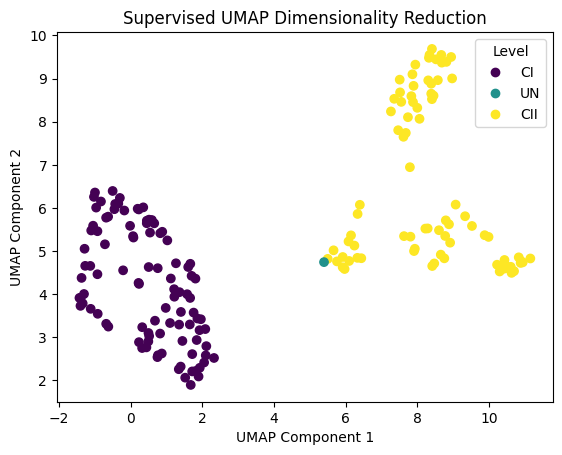

In [87]:
######## Visualization of the supervised UMAP of embeddings ######
from sklearn.decomposition import PCA
import umap

import umap.plot
supervised_umap_2 = umap.UMAP(n_components=2, random_state=42,n_epochs=100).fit(sequence_embeddings_CI, results)

# 
import matplotlib.pyplot as plt

scatter=plt.scatter(supervised_umap_2.embedding_[:, 0], supervised_umap_2.embedding_[:, 1], c=results, cmap='viridis', alpha=1)
handles = [plt.Line2D([], [], marker='o', linestyle='', color=scatter.cmap(scatter.norm(i)), label=level) for i, level in enumerate(unique_levels)]
plt.legend(handles=handles, title="Level")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("Supervised UMAP Dimensionality Reduction")
plt.show()

(265, 1280)


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.


['CIII', 'CI', 'CII']


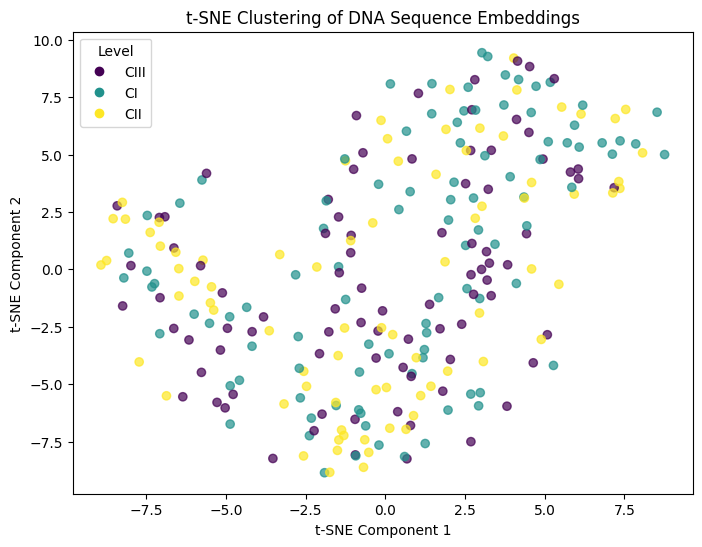

In [22]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

sequence_embeddings_CI = np.mean(embeddings_CI, axis=1)
print(sequence_embeddings_CI.shape)

# 2. PCA to 50 
pca = PCA(n_components=50)
pca_embeddings = pca.fit_transform(sequence_embeddings_CI) 

# 3. tsne to 2
tsne = TSNE(n_components=2, perplexity=50, random_state=20)
tsne_embeddings = tsne.fit_transform(pca_embeddings) 

levels=df[df['Results'].isin(['CI', 'CII', 'CIII'])]['Results']
unique_levels = list(set(levels))  
print(unique_levels)
level_to_color = {level: i for i, level in enumerate(unique_levels)}  
level_colors = [level_to_color[level] for level in levels]  

plt.figure(figsize=(8, 6))

scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=level_colors, cmap="viridis", alpha=0.7)
handles = [plt.Line2D([], [], marker='o', linestyle='', color=scatter.cmap(scatter.norm(i)), label=level) for i, level in enumerate(unique_levels)]
plt.legend(handles=handles, title="Level")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Clustering of DNA Sequence Embeddings")
plt.show()